In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns
import math

from scipy.stats import binned_statistic

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get nodal and elemental connectivity
# read elemental nodal information
cz_ele_info = pd.read_csv('czm_post/cz_ele_info.txt', header=None) 
cz_index = cz_ele_info[0].to_numpy()
cz_ele_info = cz_ele_info.set_index([0])

bulk_ele_info = pd.read_csv('czm_post/bulk_ele_info.txt', header=None) 
bulk_index = bulk_ele_info[0].to_numpy()
bulk_ele_info = bulk_ele_info.set_index([0])

node_info = pd.read_csv('czm_post/node_info.txt', header=None)

# # index
num_cz = cz_ele_info.shape[0]
num_bulk = bulk_ele_info.shape[0]
num_node = node_info.shape[0]


In [3]:
#collect all field data and all parsed displacement data

df_temp = pd.read_fwf('czm_post/830B_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_830B = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/830B_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_830B_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/830B_100stiff_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_830B_100stiff_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]

df_temp = pd.read_fwf('czm_post/860D_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_860D = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/860D_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_860D_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/860D_100stiff_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_860D_100stiff_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]

# collect field data
nu1_830B = pd.read_csv('czm_post/830B_bend90_20stiff_nu1_output.csv')
nu2_830B = pd.read_csv('czm_post/830B_bend90_20stiff_nu2_output.csv')
nx_830B = pd.read_csv('czm_post/830B_bend90_20stiff_nx_output.csv')
ny_830B = pd.read_csv('czm_post/830B_bend90_20stiff_ny_output.csv')

nu1_830B_100shear = pd.read_csv('czm_post/830B_bend90_20stiff_100shear_nu1_output.csv')
nu2_830B_100shear = pd.read_csv('czm_post/830B_bend90_20stiff_100shear_nu2_output.csv')
nx_830B_100shear = pd.read_csv('czm_post/830B_bend90_20stiff_100shear_nx_output.csv')
ny_830B_100shear = pd.read_csv('czm_post/830B_bend90_20stiff_100shear_ny_output.csv')

nu1_830B_100stiff_100shear = pd.read_csv('czm_post/830B_bend90_100stiff_100shear_nu1_output.csv')
nu2_830B_100stiff_100shear = pd.read_csv('czm_post/830B_bend90_100stiff_100shear_nu2_output.csv')
nx_830B_100stiff_100shear = pd.read_csv('czm_post/830B_bend90_100stiff_100shear_nx_output.csv')
ny_830B_100stiff_100shear = pd.read_csv('czm_post/830B_bend90_100stiff_100shear_ny_output.csv')

nu1_860D = pd.read_csv('czm_post/860D_bend90_20stiff_nu1_output.csv')
nu2_860D = pd.read_csv('czm_post/860D_bend90_20stiff_nu2_output.csv')
nx_860D = pd.read_csv('czm_post/860D_bend90_20stiff_nx_output.csv')
ny_860D = pd.read_csv('czm_post/860D_bend90_20stiff_ny_output.csv')

nu1_860D_100shear = pd.read_csv('czm_post/860D_bend90_20stiff_100shear_nu1_output.csv')
nu2_860D_100shear = pd.read_csv('czm_post/860D_bend90_20stiff_100shear_nu2_output.csv')
nx_860D_100shear = pd.read_csv('czm_post/860D_bend90_20stiff_100shear_nx_output.csv')
ny_860D_100shear = pd.read_csv('czm_post/860D_bend90_20stiff_100shear_ny_output.csv')

nu1_860D_100stiff_100shear = pd.read_csv('czm_post/860D_bend90_100stiff_100shear_nu1_output.csv')
nu2_860D_100stiff_100shear = pd.read_csv('czm_post/860D_bend90_100stiff_100shear_nu2_output.csv')
nx_860D_100stiff_100shear = pd.read_csv('czm_post/860D_bend90_100stiff_100shear_nx_output.csv')
ny_860D_100stiff_100shear = pd.read_csv('czm_post/860D_bend90_100stiff_100shear_ny_output.csv')



In [4]:
# Calculate the x coordinates (center) of each cz_ele
# thickness of each cz_ele (measure opening)

cz_center = np.empty([num_cz, 2])
cz_delta_beginning = np.empty([num_cz])

cz_delta_830B = np.empty([num_cz])
cz_delta_830B_100shear = np.empty([num_cz])
cz_delta_830B_100stiff_100shear = np.empty([num_cz])

cz_delta_860D = np.empty([num_cz])
cz_delta_860D_100shear = np.empty([num_cz])
cz_delta_860D_100stiff_100shear = np.empty([num_cz])

for i in range(0, num_cz):
    cz_i = cz_index[i]
    # for each cz, average the x coord of its four nodes

    #830B
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_830B[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_830B[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_830B[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_830B[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_830B[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_830B[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_830B[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_830B[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_830B[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # 830B_100shear
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_830B_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_830B_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_830B_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_830B_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_830B_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_830B_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_830B_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_830B_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_830B_100shear[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # 830B_100stiff_100shear
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_830B_100stiff_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_830B_100stiff_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_830B_100stiff_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_830B_100stiff_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_830B_100stiff_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_830B_100stiff_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_830B_100stiff_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_830B_100stiff_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_830B_100stiff_100shear[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # 860D
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_860D[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_860D[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_860D[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_860D[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_860D[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_860D[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_860D[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_860D[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_860D[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # 860D_100shear
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_860D_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_860D_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_860D_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_860D_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_860D_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_860D_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_860D_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_860D_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_860D_100shear[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # 860D_100stiff_100shear
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0
    ct_x_b = nx_860D_100stiff_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + nx_860D_100stiff_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny_860D_100stiff_100shear[str(cz_ele_info[1][cz_i])].iloc[-1] + ny_860D_100stiff_100shear[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_x_t = nx_860D_100stiff_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + nx_860D_100stiff_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny_860D_100stiff_100shear[str(cz_ele_info[3][cz_i])].iloc[-1] + ny_860D_100stiff_100shear[str(cz_ele_info[4][cz_i])].iloc[-1]
    cz_delta_860D_100stiff_100shear[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    # center location of each cohesive element (potentially a bug)
    cz_center[i, 0] = (ct_x_b + ct_x_t) / 4
    cz_center[i, 1] = (ct_y_b + ct_y_t) / 4

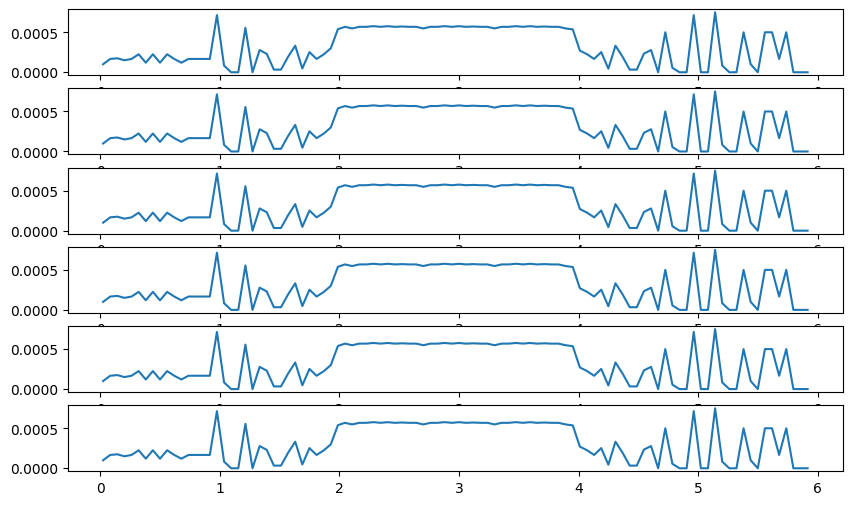

In [5]:
# Compare crack opening
mean_stat_830B = binned_statistic(cz_center[:, 0], cz_delta_830B, statistic='mean', bins=100)
mean_stat_830B_100shear = binned_statistic(cz_center[:, 0], cz_delta_830B_100shear, statistic='mean', bins=100)
mean_stat_830B_100stiff_100shear = binned_statistic(cz_center[:, 0], cz_delta_830B_100stiff_100shear, statistic='mean', bins=100)

mean_stat_860D = binned_statistic(cz_center[:, 0], cz_delta_860D, statistic='mean', bins=100)
mean_stat_860D_100shear = binned_statistic(cz_center[:, 0], cz_delta_860D_100shear, statistic='mean', bins=100)
mean_stat_860D_100stiff_100shear = binned_statistic(cz_center[:, 0], cz_delta_860D_100stiff_100shear, statistic='mean', bins=100)


fig_open, ax_open = plt.subplots(6,1,figsize=(10,6))
ax_open[0].plot( mean_stat_830B.bin_edges[0:-1], mean_stat_830B.statistic, label='830B')
ax_open[1].plot( mean_stat_830B_100shear.bin_edges[0:-1], mean_stat_830B_100shear.statistic, label='830B 100shear')
ax_open[2].plot( mean_stat_830B_100stiff_100shear.bin_edges[0:-1], mean_stat_830B_100stiff_100shear.statistic, label='830B 100stiff 100shear')

ax_open[3].plot( mean_stat_860D.bin_edges[0:-1], mean_stat_860D.statistic, label='860D')
ax_open[4].plot( mean_stat_860D_100shear.bin_edges[0:-1], mean_stat_860D_100shear.statistic, label='860D 100shear')
ax_open[5].plot( mean_stat_860D_100stiff_100shear.bin_edges[0:-1], mean_stat_860D_100stiff_100shear.statistic, label='860D 100stiff 100shear')


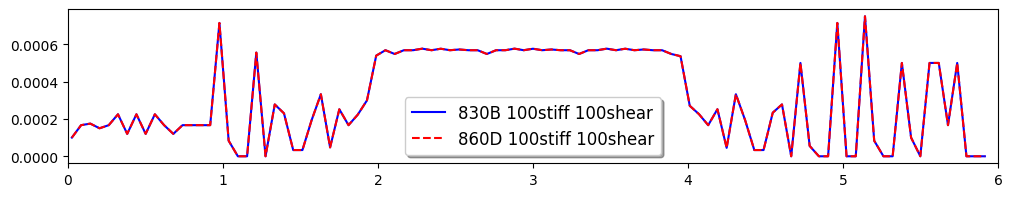

In [6]:
# Compare crack opening

fig_open, ax = plt.subplots(figsize=(12,2))
ax.plot( mean_stat_830B_100stiff_100shear.bin_edges[0:-1], mean_stat_830B_100stiff_100shear.statistic, 'b', label='830B 100stiff 100shear')
ax.plot( mean_stat_860D_100stiff_100shear.bin_edges[0:-1], mean_stat_860D_100stiff_100shear.statistic, 'r--', label='860D 100stiff 100shear')
ax.set_xlim([0, 6])

legend = ax.legend(loc='lower center', shadow=True, fontsize='large')

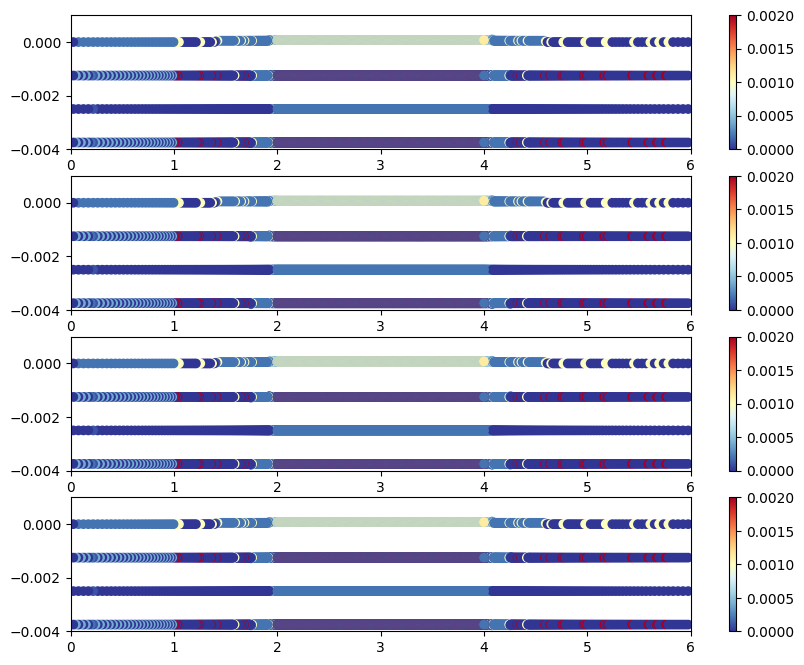

In [7]:
# Plot the stress field
cm = plt.cm.get_cmap('RdYlBu_r')
fig_open_field, ax_open_field = plt.subplots(4,1,figsize=(10,8))

t0 = ax_open_field[0].scatter( cz_center[:,0], cz_center[:,1], c = cz_delta_830B, label='830B', vmin=0, vmax=0.002, cmap=cm)
ax_open_field[0].set_ylim([-0.004,0.001])
ax_open_field[0].set_xlim([0,6])
plt.colorbar(t0)

t1 = ax_open_field[1].scatter( cz_center[:,0], cz_center[:,1], c = cz_delta_830B_100shear, label='830B 100shear', vmin=0, vmax=0.002, cmap=cm)
ax_open_field[1].set_ylim([-0.004,0.001])
ax_open_field[1].set_xlim([0,6])
plt.colorbar(t1)

t2 = ax_open_field[2].scatter( cz_center[:,0], cz_center[:,1], c = cz_delta_860D, label='860D', vmin=0, vmax=0.002, cmap=cm)
ax_open_field[2].set_ylim([-0.004,0.001])
ax_open_field[2].set_xlim([0,6])
plt.colorbar(t2)

t3 = ax_open_field[3].scatter( cz_center[:,0], cz_center[:,1], c = cz_delta_860D_100shear, label='860D 100shear', vmin=0, vmax=0.002, cmap=cm)
ax_open_field[3].set_ylim([-0.004,0.001])
ax_open_field[3].set_xlim([0,6])
plt.colorbar(t3)


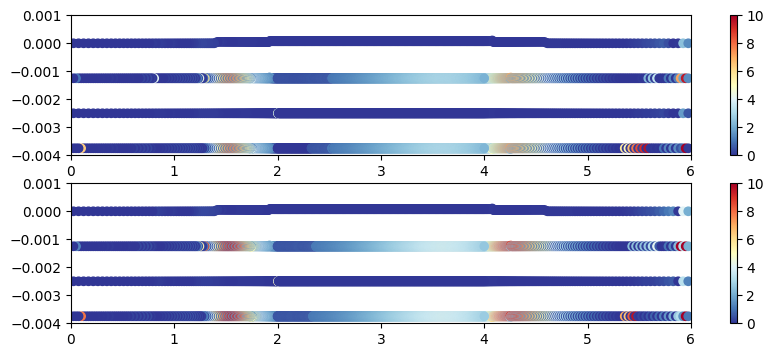

In [22]:
# Plot the stress field
cm = plt.cm.get_cmap('RdYlBu_r')
fig_open_field, ax_open_field = plt.subplots(2,1,figsize=(10,4))

t0 = ax_open_field[0].scatter( cz_center[:,0], cz_center[:,1], c = cz_stress_830B_100shear.loc[1000,:], label='830B', vmin=0, vmax=10, cmap=cm)
ax_open_field[0].set_ylim([-0.004,0.001])
ax_open_field[0].set_xlim([0,6])
plt.colorbar(t0)

t1 = ax_open_field[1].scatter( cz_center[:,0], cz_center[:,1], c = cz_stress_860D_100shear.loc[1000,:], label='830B 100shear', vmin=0, vmax=10, cmap=cm)
ax_open_field[1].set_ylim([-0.004,0.001])
ax_open_field[1].set_xlim([0,6])
plt.colorbar(t1)


In [18]:
cz_stress_830B_100stiff_100shear

,1,3,5,7,9,11,13,15,17,19,...,12577,12579,12581,12583,12585,12587,12589,12591,12593,12595
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000013,0.000197,0.00735,0.000017,0.000008,0.00717,0.000009,0.000258,0.00756,0.000022,...,0.000217,0.000215,0.000211,0.000203,0.000190,0.000169,0.000137,0.000115,0.000144,0.000260
2,0.000004,0.000018,0.00415,0.000005,0.000005,0.00360,0.000005,0.000036,0.00424,0.000007,...,0.000391,0.000389,0.000387,0.000382,0.000374,0.000361,0.000339,0.000301,0.000241,0.000155
3,0.012000,0.000232,0.00740,0.008700,0.015100,0.01010,0.011900,0.000283,0.00751,0.009050,...,0.000519,0.000519,0.000521,0.000526,0.000534,0.000548,0.000573,0.000615,0.000684,0.000788
4,0.041300,0.000681,0.02960,0.037000,0.045600,0.03360,0.041500,0.000849,0.02980,0.038000,...,0.000620,0.000623,0.000630,0.000646,0.000673,0.000719,0.000801,0.000941,0.001170,0.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,10.600000,0.104000,8.17000,10.300000,10.900000,8.50000,10.700000,0.145000,8.14000,10.600000,...,0.028900,0.028700,0.028300,0.026600,0.023900,0.019600,0.012400,0.001560,0.023200,0.117000
999,10.600000,0.104000,8.17000,10.300000,10.900000,8.50000,10.700000,0.145000,8.14000,10.500000,...,0.028900,0.028800,0.028300,0.026600,0.023900,0.019600,0.012400,0.001570,0.023200,0.117000
1000,10.600000,0.104000,8.16000,10.300000,10.800000,8.49000,10.700000,0.145000,8.14000,10.500000,...,0.028900,0.028800,0.028300,0.026600,0.023900,0.019600,0.012400,0.001570,0.023200,0.117000
1001,10.600000,0.104000,8.16000,10.300000,10.800000,8.49000,10.600000,0.145000,8.13000,10.500000,...,0.028900,0.028800,0.028300,0.026600,0.023900,0.019700,0.012400,0.001580,0.023200,0.117000


In [9]:
cz_stress_830B_100stiff_100shear.loc[1000,:]

1           10.6
3          0.104
5           8.16
7           10.3
9           10.8
          ...   
12587     0.0196
12589     0.0124
12591    0.00157
12593     0.0232
12595      0.117
Name: 1000, Length: 6298, dtype: object

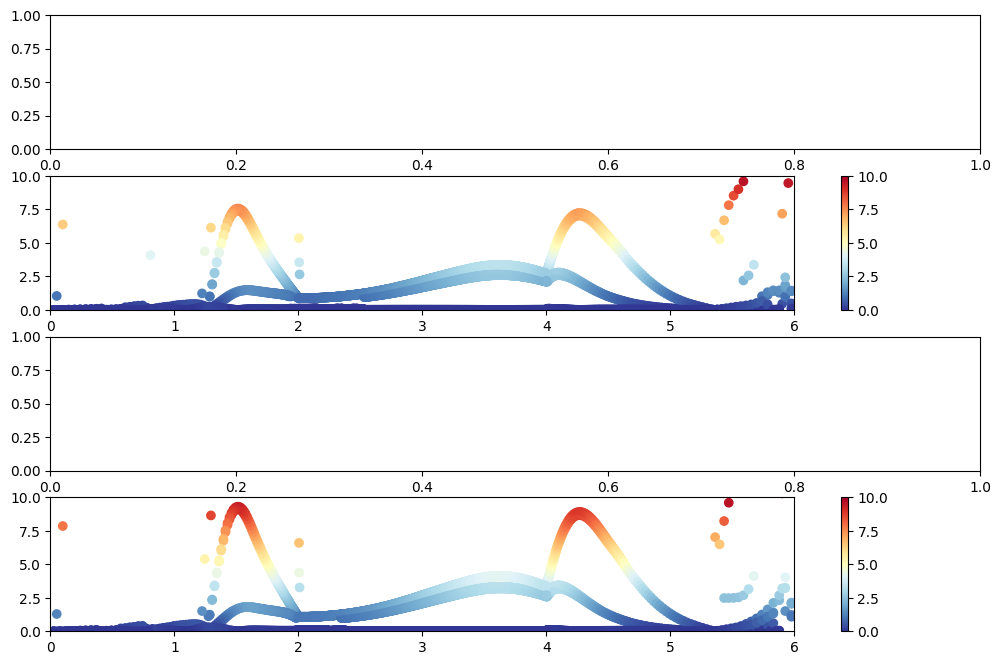

In [10]:
# Plot the stress field
cm = plt.cm.get_cmap('RdYlBu_r')

fig_stress, ax_stress = plt.subplots(4,1,figsize=(12,8))

# t = ax_stress[0].scatter( cz_center[:,0], cz_stress_830B_100stiff_100shear.loc[1000,:], label='830B', c=cz_stress_830B_100stiff_100shear.loc[1000,:], vmin=0, vmax=10, cmap=cm)
# plt.colorbar(t)
# ax_stress[0].set_ylim([0,10])
# ax_stress[0].set_xlim([0,6])

t1 = ax_stress[1].scatter( cz_center[:,0], cz_stress_830B_100shear.loc[1000,:], label='830B 100shear', c=cz_stress_830B_100shear.loc[1000,:], vmin=0, vmax=10, cmap=cm)
ax_stress[1].set_ylim([0,10])
ax_stress[1].set_xlim([0,6])
plt.colorbar(t1)

# t2 = ax_stress[2].scatter( cz_center[:,0], cz_stress_860D_100stiff_100shear.loc[1000,:], label='860D', c=cz_stress_860D_100stiff_100shear.loc[1000,:], vmin=0, vmax=10, cmap=cm)
# ax_stress[2].set_ylim([0,10])
# ax_stress[2].set_xlim([0,6])
# plt.colorbar(t2)

t3 = ax_stress[3].scatter( cz_center[:,0], cz_stress_860D_100shear.loc[1000,:], label='860D 100shear', c=cz_stress_860D_100shear.loc[1000,:], vmin=0, vmax=10, cmap=cm)
ax_stress[3].set_ylim([0,10])
ax_stress[3].set_xlim([0,6])
plt.colorbar(t3)


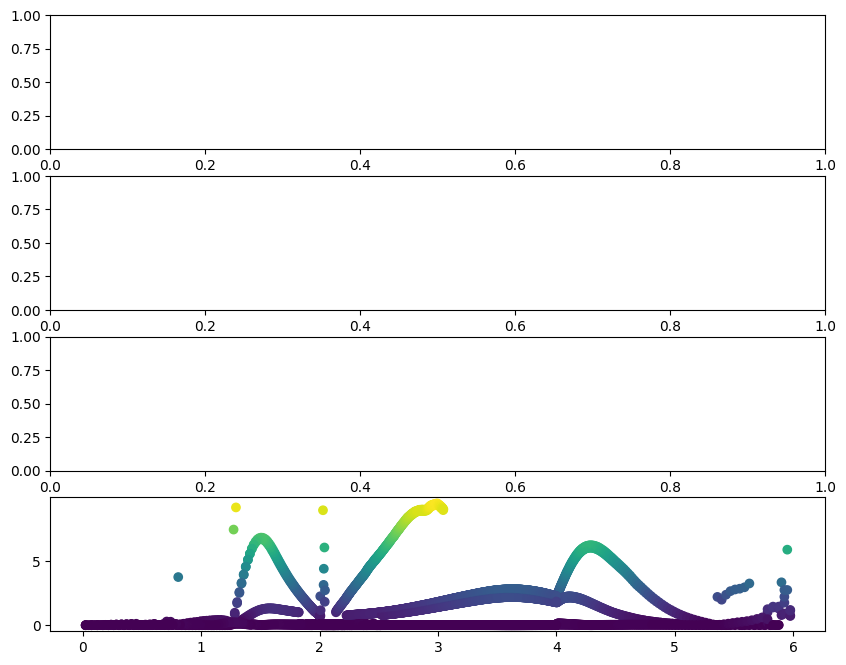

In [11]:
fig_t= plt.subplots(4,1,figsize=(10,8))
plt.scatter( cz_center[:,0], cz_stress_830B.loc[1000,:], label='830B', c=cz_stress_830B.loc[1000,:])

In [12]:
cz_stress_830B.shape

(1001, 6298)

In [13]:
cz_stress_830B

,1,3,5,7,9,11,13,15,17,19,...,12577,12579,12581,12583,12585,12587,12589,12591,12593,12595
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.910000e-06,0.000047,0.001600,0.000004,0.000002,0.001570,0.000002,0.000063,0.001650,0.000005,...,0.000048,0.000047,0.000046,0.000045,0.000042,0.000037,0.000029,0.000024,0.000032,0.000061
2,9.040000e-07,0.000005,0.000903,0.000001,0.000001,0.000787,0.000001,0.000009,0.000926,0.000002,...,0.000091,0.000091,0.000090,0.000089,0.000087,0.000084,0.000079,0.000070,0.000056,0.000037
3,2.680000e-03,0.000048,0.001610,0.001870,0.003340,0.002200,0.002580,0.000061,0.001640,0.001950,...,0.000125,0.000125,0.000126,0.000127,0.000128,0.000132,0.000138,0.000148,0.000165,0.000191
4,9.090000e-03,0.000150,0.006460,0.008050,0.010000,0.007330,0.009020,0.000192,0.006500,0.008300,...,0.000153,0.000154,0.000155,0.000159,0.000165,0.000176,0.000195,0.000229,0.000285,0.000382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035800,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003220,0.000334,0.008650,0.032800
997,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003220,0.000335,0.008640,0.032800
998,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003230,0.000337,0.008640,0.032800
999,2.320000e+00,0.025000,1.790000,2.260000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003230,0.000339,0.008630,0.032800


In [14]:

df_temp = pd.read_fwf('czm_post/830B_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_830B = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/830B_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_830B_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]

df_temp = pd.read_fwf('czm_post/860D_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_860D = df_temp.loc[:, 1:df_temp.shape[1]:2]
df_temp = pd.read_fwf('czm_post/860D_100shear_cz_maxprincipalstress.rpt', sep=' ', skiprows=7, header=None)
cz_stress_860D_100shear = df_temp.loc[:, 1:df_temp.shape[1]:2]

In [15]:
cz_stress_830B

,1,3,5,7,9,11,13,15,17,19,...,12577,12579,12581,12583,12585,12587,12589,12591,12593,12595
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.910000e-06,0.000047,0.001600,0.000004,0.000002,0.001570,0.000002,0.000063,0.001650,0.000005,...,0.000048,0.000047,0.000046,0.000045,0.000042,0.000037,0.000029,0.000024,0.000032,0.000061
2,9.040000e-07,0.000005,0.000903,0.000001,0.000001,0.000787,0.000001,0.000009,0.000926,0.000002,...,0.000091,0.000091,0.000090,0.000089,0.000087,0.000084,0.000079,0.000070,0.000056,0.000037
3,2.680000e-03,0.000048,0.001610,0.001870,0.003340,0.002200,0.002580,0.000061,0.001640,0.001950,...,0.000125,0.000125,0.000126,0.000127,0.000128,0.000132,0.000138,0.000148,0.000165,0.000191
4,9.090000e-03,0.000150,0.006460,0.008050,0.010000,0.007330,0.009020,0.000192,0.006500,0.008300,...,0.000153,0.000154,0.000155,0.000159,0.000165,0.000176,0.000195,0.000229,0.000285,0.000382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035800,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003220,0.000334,0.008650,0.032800
997,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003220,0.000335,0.008640,0.032800
998,2.320000e+00,0.025000,1.790000,2.270000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003230,0.000337,0.008640,0.032800
999,2.320000e+00,0.025000,1.790000,2.260000,2.380000,1.860000,2.330000,0.035700,1.780000,2.320000,...,0.006960,0.006940,0.006890,0.006570,0.005960,0.004970,0.003230,0.000339,0.008630,0.032800


In [16]:
cz_delta_830B.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [ ]:
min(cz_center[:,1])